<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/post_covid_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###univariate time series LSTM first try

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

nb observations: 510


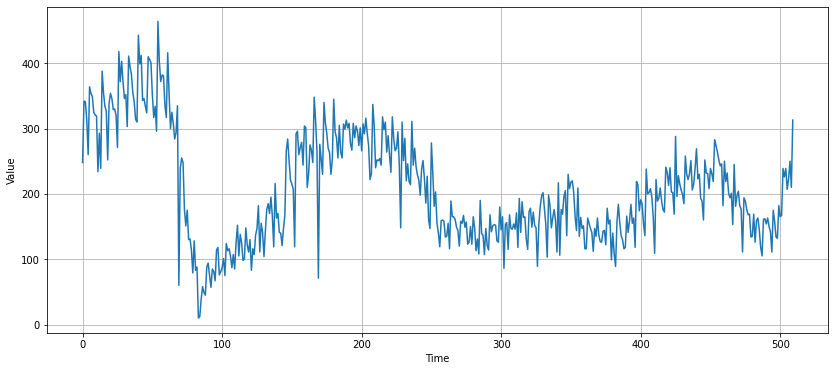

In [28]:
#df = pd.read_csv('reffined_data.csv')
df1 = pd.read_csv('data_pca_dt_covid_fi.csv')
df2 = pd.read_csv('test_data_pca_dt_covid_fi.csv')
df = pd.concat([df1, df2], axis = 0, ignore_index=True)
df = df.iloc[1826:]
df = df.iloc[:510]
series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(14, 6))
plot_series(time, series)
print('nb observations:', df.shape[0])

Clean data by removing the three pics from the series

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))


split_time = 340  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 30

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)

total (510, 1)
train (340, 1)
test (170, 1)


In [30]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 32 #128
shuffle_buffer = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  #tf.keras.layers.MaxPool1D(pool_size=2),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.95)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])

train_set=  <PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (340, 1)
Epoch 1/20
11/11 [==============================] - 2s 23ms/step - loss: 0.4157 - mae: 0.7750
Epoch 2/20
11/11 [==============================] - 0s 25ms/step - loss: 0.2068 - mae: 0.4767
Epoch 3/20
11/11 [==============================] - 0s 25ms/step - loss: 0.1176 - mae: 0.3617
Epoch 4/20
11/11 [==============================] - 0s 23ms/step - loss: 0.0833 - mae: 0.2983
Epoch 5/20
11/11 [==============================] - 0s 24ms/step - loss: 0.0611 - mae: 0.2626
Epoch 6/20
11/11 [==============================] - 0s 23ms/step - loss: 0.0445 - mae: 0.2211
Epoch 7/20
11/11 [==============================] - 0s 25ms/step - loss: 0.0330 - mae: 0.1930
Epoch 8/20
11/11 [==============================] - 0s 23ms/step - loss: 0.0292 - mae: 0.1812
Epoch 9/20
11/11 [==============================] - 0s 25ms/step - loss: 0.0229 - mae: 0.1603
Epoch 10/20
11/

In [32]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [33]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",scaler.inverse_transform(np.squeeze(rnn_forecast)))
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[225.06212 285.6212  322.4434  ... 303.24753 315.96643 327.31265]
 [275.3213  329.69873 318.20203 ... 288.2604  318.65115 361.20486]
 [274.6861  325.77505 304.39093 ... 335.96423 326.97177 367.98956]
 ...
 [179.71228 169.07239 228.76627 ... 210.34912 194.85199 202.49907]
 [220.09042 225.14468 255.2721  ... 208.96228 205.70523 234.21837]
 [212.90555 219.76465 250.76276 ... 215.86511 202.54114 248.0494 ]]
(504, 7, 1)

2 [170]


In [34]:
#results['Date'] = df['Date']
pred = pd.DataFrame(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))
real = pd.DataFrame(scaler.inverse_transform(x_valid))

results = pd.concat([real,pred, real-pred], axis = 1)
#results = results.rename(columns={0: ('flux_réel', 'prediction')})
print('Max = ', max(results.iloc[:,2]))
print('Min = ', min(results.iloc[:,2]))
print([int(i) for i in list(results.iloc[:,2])])
results

Max =  80.26127624511722
Min =  -85.3614501953125
[-54, 55, -57, 11, 12, 25, 53, -22, 66, 42, 27, 34, -13, -10, -45, 18, -61, -27, -26, -22, -46, -47, 17, 0, -2, 2, -25, -4, -18, 11, -8, -15, -17, -6, -6, -25, 39, 9, 11, -46, -7, -45, -71, 22, 48, 19, -6, 0, -35, -38, 9, -13, 15, 44, 10, 12, -35, 59, 48, -9, 28, 30, -16, -47, 55, 6, 10, 28, 17, -12, -83, 37, 0, -4, 34, 11, 10, -12, 49, 37, -3, 29, 14, 13, -27, 75, -36, -11, 7, 8, 6, -19, 27, 17, -20, 18, 51, 3, 7, 5, 46, -19, -14, -32, -17, -53, 40, -8, -11, -12, 47, 43, 14, 43, 30, 7, 6, -8, -8, -85, -37, -54, -37, -36, -49, 3, -48, 35, -30, -33, 20, -18, -2, -80, 9, 7, -15, 0, 1, -28, -35, -1, -41, 0, 12, -11, -32, -43, 14, 7, 3, 20, 13, -9, -43, 17, 0, -20, -13, 42, 11, 12, 80, 63, 75, 35, 44, 65, 7, 78]


,0,0,0
0,111.0,165.748413,-54.748413
1,217.0,161.256546,55.743454
2,106.0,163.717346,-57.717346
3,176.0,164.764008,11.235992
4,169.0,156.605423,12.394577
...,...,...,...
165,207.0,171.804199,35.195801
166,223.0,178.879257,44.120743
167,250.0,184.854523,65.145477
168,210.0,202.499069,7.500931


(170,)
(170, 1)
(170,)


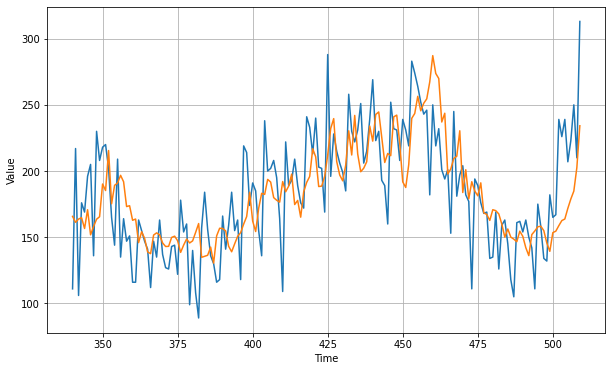

In [35]:
print(time_valid.shape)      
print(x_valid.shape)         
print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, scaler.inverse_transform(x_valid)) # 2-D
plot_series(time_valid, scaler.inverse_transform(rnn_forecast.reshape(-1,1))) # we only took the last part of the rnn_forecast

In [36]:
tf.keras.metrics.mean_absolute_error(np.squeeze(x_valid), np.squeeze(rnn_forecast)).numpy() # CNN LSTM 1.77

0.05849643

In [37]:
tf.keras.metrics.mean_absolute_percentage_error(np.squeeze(x_valid), np.squeeze(rnn_forecast)).numpy() # CNN LSTM 1.77

16.698843

In [38]:
tf.keras.metrics.mean_absolute_error(np.squeeze(scaler.inverse_transform(x_valid)), np.squeeze(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))).numpy() # CNN LSTM 1.77


26.557379